# Google Analytics Customer Revenue Prediction

### Group Members
* Zili Bu
* Hsin-Yu Chen
* Kexin Zhang
* Huang-Chin Ye

### Executive Summary

### Introduction
* What dataset you used and your initial plan

We found Google Analytics Customer Revenue Prediction dataset from Kaggle. Our initial plan is to clean the dataset, explore the dataset by plots, use spark sql to do further analysis to get an insight about user behaviors. 

### Exploratory analysis section
* Any insights you've learned from the data (with charts to illustrate)

In [1]:
# import needed libraries
import pandas as pd
import numpy as np

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark import SparkContext
sc = SparkContext()

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
spark = SparkSession.builder.appName("Project-DNSC6290").getOrCreate()

In [5]:
from time import time

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import json # to convert json in df
from pandas.io.json import json_normalize # to normalize the json file
import os # it's a operational system library, to set some informations

## Convert Json Columns

In [8]:
#dir_path = "/Users/hyen86/BigData/Project/"
def load_df(df, nrows = None):
    #Columns that have json format
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    #nrows = None
    
    df = pd.read_csv(df, 
                converters={column: json.loads for column in json_columns}, 
                dtype={'fullVisitorId': 'str'}, # Important!!
                nrows=nrows)
    
    for column in json_columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Shape: {df.shape}")
    return df

In [9]:
#call the function
data = load_df("train_v2.csv")

Shape: (1708337, 60)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 60 columns):
channelGrouping                                      object
customDimensions                                     object
date                                                 int64
fullVisitorId                                        object
hits                                                 object
socialEngagementType                                 object
visitId                                              int64
visitNumber                                          int64
visitStartTime                                       int64
device.browser                                       object
device.browserVersion                                object
device.browserSize                                   object
device.operatingSystem                               object
device.operatingSystemVersion                        object
device.isMobile                                    

In [11]:
# data.to_csv('load_df_data.csv', index=False)

In [12]:
# Check missing values fro each column
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print("Total columns at least one Values: ")
    print(df.loc[df['Total'] >0])
    return

In [13]:
missing_values(data)

Total columns at least one Values: 
                                                Total    Percent
trafficSource.campaignCode                    1708336  99.999941
totals.totalTransactionRevenue                1689823  98.916256
totals.transactionRevenue                     1689823  98.916256
totals.transactions                           1689778  98.913622
trafficSource.adContent                       1643600  96.210525
trafficSource.adwordsClickInfo.adNetworkType  1633063  95.593727
trafficSource.adwordsClickInfo.slot           1633063  95.593727
trafficSource.adwordsClickInfo.page           1633063  95.593727
trafficSource.adwordsClickInfo.isVideoAd      1633063  95.593727
trafficSource.adwordsClickInfo.gclId          1632914  95.585005
trafficSource.isTrueDirect                    1173819  68.711209
trafficSource.referralPath                    1142073  66.852910
trafficSource.keyword                         1052780  61.626014
totals.timeOnSite                              874294 

In [14]:
for item in list(data.columns):
    print(list(data.columns).index(item), item)

0 channelGrouping
1 customDimensions
2 date
3 fullVisitorId
4 hits
5 socialEngagementType
6 visitId
7 visitNumber
8 visitStartTime
9 device.browser
10 device.browserVersion
11 device.browserSize
12 device.operatingSystem
13 device.operatingSystemVersion
14 device.isMobile
15 device.mobileDeviceBranding
16 device.mobileDeviceModel
17 device.mobileInputSelector
18 device.mobileDeviceInfo
19 device.mobileDeviceMarketingName
20 device.flashVersion
21 device.language
22 device.screenColors
23 device.screenResolution
24 device.deviceCategory
25 geoNetwork.continent
26 geoNetwork.subContinent
27 geoNetwork.country
28 geoNetwork.region
29 geoNetwork.metro
30 geoNetwork.city
31 geoNetwork.cityId
32 geoNetwork.networkDomain
33 geoNetwork.latitude
34 geoNetwork.longitude
35 geoNetwork.networkLocation
36 totals.visits
37 totals.hits
38 totals.pageviews
39 totals.bounces
40 totals.newVisits
41 totals.sessionQualityDim
42 totals.timeOnSite
43 totals.transactions
44 totals.transactionRevenue
45 total

From above function, we can see some columns are having a lot of null values. Therefore, we deceided to drop all columns that have around or above 50% null vlaue. We drop all the trafficSource related columns.

In [15]:
# We dropped 17 columns
dataNew = data.drop(data.columns[[1, 4, 39, 41, 42, 43, 45, 49, 52, 51, 53, 54, 55, 56, 57, 58 ,59]], axis=1)

In [16]:
dataNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 43 columns):
channelGrouping                                      object
date                                                 int64
fullVisitorId                                        object
socialEngagementType                                 object
visitId                                              int64
visitNumber                                          int64
visitStartTime                                       int64
device.browser                                       object
device.browserVersion                                object
device.browserSize                                   object
device.operatingSystem                               object
device.operatingSystemVersion                        object
device.isMobile                                      bool
device.mobileDeviceBranding                          object
device.mobileDeviceModel                             

In [17]:
data_constCol = [c for c in dataNew.columns if dataNew[c].nunique()==1]

In [18]:
data_constCol

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

From above code, we find these columns are all having one constant value, which are not informative for our analysis. We may consider to drop them.

In [19]:
dataNew2 = dataNew.drop(dataNew[data_constCol], axis=1)

In [20]:
dataNew2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 23 columns):
channelGrouping              object
date                         int64
fullVisitorId                object
visitId                      int64
visitNumber                  int64
visitStartTime               int64
device.browser               object
device.operatingSystem       object
device.isMobile              bool
device.deviceCategory        object
geoNetwork.continent         object
geoNetwork.subContinent      object
geoNetwork.country           object
geoNetwork.region            object
geoNetwork.metro             object
geoNetwork.city              object
geoNetwork.networkDomain     object
totals.hits                  object
totals.pageviews             object
totals.transactionRevenue    object
trafficSource.campaign       object
trafficSource.source         object
trafficSource.medium         object
dtypes: bool(1), int64(4), object(18)
memory usage: 288.4+ MB


### Creating the function to handle with date

In [21]:
# library of datetime
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting day
    df["year"] = df['date'].dt.year # extracting day
    df["visitHour"] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations

In [22]:
dataNew2 = date_process(dataNew2)

In [23]:
dataNew2.head(5)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,totals.pageviews,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,weekday,day,month,year,visitHour
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,Windows,False,desktop,...,1,NaN,(not set),google,organic,0,16,10,2017,20
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,Chrome OS,False,desktop,...,2,NaN,(not set),sites.google.com,referral,0,16,10,2017,13
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,Chrome,Android,True,mobile,...,2,NaN,(not set),(direct),(none),0,16,10,2017,20
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,Chrome,Windows,False,desktop,...,2,NaN,(not set),google,organic,0,16,10,2017,12
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,Chrome,Windows,False,desktop,...,2,NaN,(not set),google,organic,0,16,10,2017,17


In [25]:
dataNew2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 28 columns):
channelGrouping              object
date                         datetime64[ns]
fullVisitorId                object
visitId                      int64
visitNumber                  int64
visitStartTime               int64
device.browser               object
device.operatingSystem       object
device.isMobile              bool
device.deviceCategory        object
geoNetwork.continent         object
geoNetwork.subContinent      object
geoNetwork.country           object
geoNetwork.region            object
geoNetwork.metro             object
geoNetwork.city              object
geoNetwork.networkDomain     object
totals.hits                  object
totals.pageviews             object
totals.transactionRevenue    object
trafficSource.campaign       object
trafficSource.source         object
trafficSource.medium         object
weekday                      int64
day                  

### Convert the str in totals.* columns to the proper format.

In [26]:
dataNew2["totals.transactionRevenue"] = dataNew2["totals.transactionRevenue"].astype('float')
dataNew2["totals.hits"] = dataNew2["totals.hits"].astype('float')
dataNew2["totals.pageviews"] = dataNew2["totals.pageviews"].astype('float')
#convert the datetype of revenue to float format

In [27]:
dataNew2["totals.transactionRevenue"].fillna(0, inplace=True) # fill all the rows with N/A in transctions with 0
dataNew2["totals.transactionRevenue"].isna().sum() # Now, it should have 0 N/A value

0

In [28]:
dataNew2["totals.hits"].isna().sum()# check N/A value in total.hits

0

In [29]:
dataNew2["totals.pageviews"].fillna(0, inplace=True)# fill all the rows with N/A in transctions with 0
dataNew2["totals.pageviews"].isna().sum()# Now, it should have 0 N/A value

0

In [30]:
# dataNew2.to_csv('data_clean.csv', index=False)

## EDA

### Create Spark Dataframe

In [8]:
sparkDF = spark.read\
    .format('csv')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .load('s3://largedataset-project/data_clean.csv')

In [9]:
sparkDF.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- fullVisitorId: decimal(20,0) (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- visitStartTime: integer (nullable = true)
 |-- device.browser: string (nullable = true)
 |-- device.operatingSystem: string (nullable = true)
 |-- device.isMobile: boolean (nullable = true)
 |-- device.deviceCategory: string (nullable = true)
 |-- geoNetwork.continent: string (nullable = true)
 |-- geoNetwork.subContinent: string (nullable = true)
 |-- geoNetwork.country: string (nullable = true)
 |-- geoNetwork.region: string (nullable = true)
 |-- geoNetwork.metro: string (nullable = true)
 |-- geoNetwork.city: string (nullable = true)
 |-- geoNetwork.networkDomain: string (nullable = true)
 |-- totals.hits: double (nullable = true)
 |-- totals.pageviews: double (nullable = true)
 |-- totals.transactionRevenue: double (nullable = true)
 |-- trafficSource.c

In [10]:
sparkDF.cache()

DataFrame[channelGrouping: string, date: timestamp, fullVisitorId: decimal(20,0), visitId: int, visitNumber: int, visitStartTime: int, device.browser: string, device.operatingSystem: string, device.isMobile: boolean, device.deviceCategory: string, geoNetwork.continent: string, geoNetwork.subContinent: string, geoNetwork.country: string, geoNetwork.region: string, geoNetwork.metro: string, geoNetwork.city: string, geoNetwork.networkDomain: string, totals.hits: double, totals.pageviews: double, totals.transactionRevenue: double, trafficSource.campaign: string, trafficSource.source: string, trafficSource.medium: string, weekday: int, day: int, month: int, year: int, visitHour: int]

In [11]:
sparkDF.createOrReplaceTempView('viewDF')

### Visit Counts

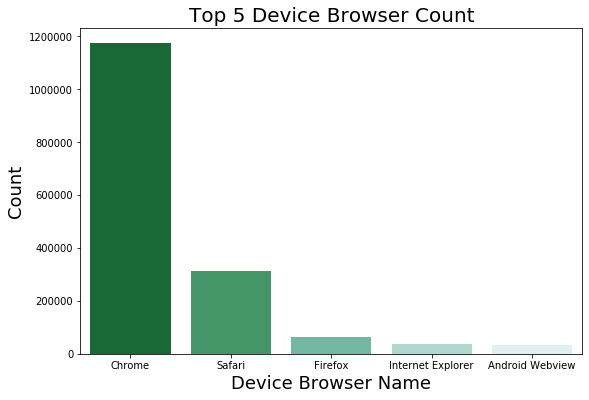

In [31]:
# seting the graph size
plt.figure(figsize=(9,6))
browser_order = dataNew2["device.browser"].value_counts()[:5].sort_values(ascending=False).index

# let explore the browser used by users
sns.countplot(dataNew2["device.browser"], order=browser_order, palette='BuGn_r')
plt.title("Top 5 Device Browser Count", fontsize=20) # seting the title size
plt.xlabel("Device Browser Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [12]:
# Top 5 Device Browser Count
spark.sql("""SELECT `device.browser`, COUNT(`device.browser`) AS Count \
            FROM viewDF \
            GROUP BY `device.browser` \
            ORDER BY COUNT(`device.browser`) DESC \
            LIMIT 5""").show()

+-----------------+-------+
|   device.browser|  Count|
+-----------------+-------+
|           Chrome|1173056|
|           Safari| 312165|
|          Firefox|  63845|
|Internet Explorer|  35474|
|  Android Webview|  34266|
+-----------------+-------+



The top 5 browsers are Chrome, Safari, Firefox, Internet Explorer, and Android Webview

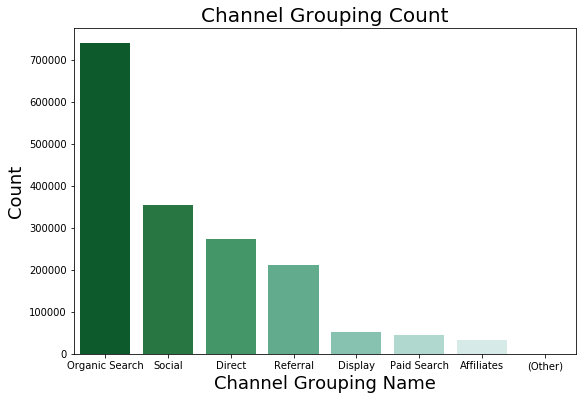

In [32]:
# seting the graph size
plt.figure(figsize=(9,6))
channel_order = dataNew2["channelGrouping"].value_counts().sort_values(ascending=False).index

sns.countplot(dataNew2["channelGrouping"], order=channel_order, palette='BuGn_r')
#Paired, Set2, hls
plt.title("Channel Grouping Count", fontsize=20) # seting the title size
plt.xlabel("Channel Grouping Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [13]:
#Channel Grouping Count
spark.sql(""" SELECT channelGrouping, COUNT(channelGrouping) AS Count 
          FROM viewDF 
          GROUP BY channelGrouping 
          ORDER BY COUNT(channelGrouping) DESC """).show()

+---------------+------+
|channelGrouping| Count|
+---------------+------+
| Organic Search|738963|
|         Social|354971|
|         Direct|273134|
|       Referral|211307|
|        Display| 51283|
|    Paid Search| 45627|
|     Affiliates| 32915|
|        (Other)|   137|
+---------------+------+



After counting the channel, we can see user used the Organic Search the most. Next are Social, Direct, and Referral.

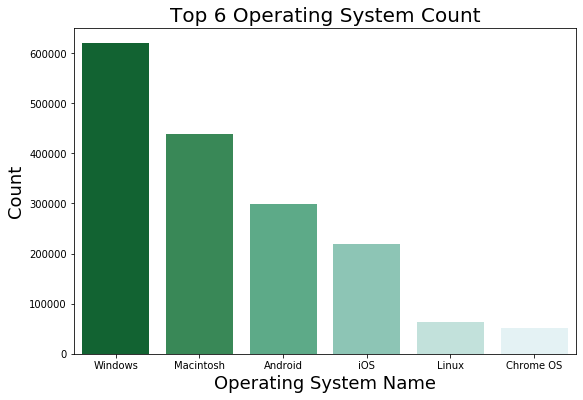

In [33]:
# Top 6 Operating System Count
plt.figure(figsize=(9,6))
operatingSystem_order = dataNew2["device.operatingSystem"].value_counts()[:6].sort_values(ascending=False).index

sns.countplot(dataNew2["device.operatingSystem"], order=operatingSystem_order, palette='BuGn_r')
plt.title("Top 6 Operating System Count", fontsize=20) # seting the title size
plt.xlabel("Operating System Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [14]:
# Top 6 Operating System Count
spark.sql("""SELECT `device.operatingSystem`, COUNT(`device.operatingSystem`) AS Count \
            FROM viewDF \
            GROUP BY `device.operatingSystem` \
            ORDER BY COUNT(`device.operatingSystem`) DESC \
            LIMIT 6""").show()

+----------------------+------+
|device.operatingSystem| Count|
+----------------------+------+
|               Windows|619720|
|             Macintosh|438514|
|               Android|299386|
|                   iOS|219334|
|                 Linux| 63971|
|             Chrome OS| 51318|
+----------------------+------+



Top 6 operating systems are Windows, Macintosh, Android, iOS, Linux, Chrome OS

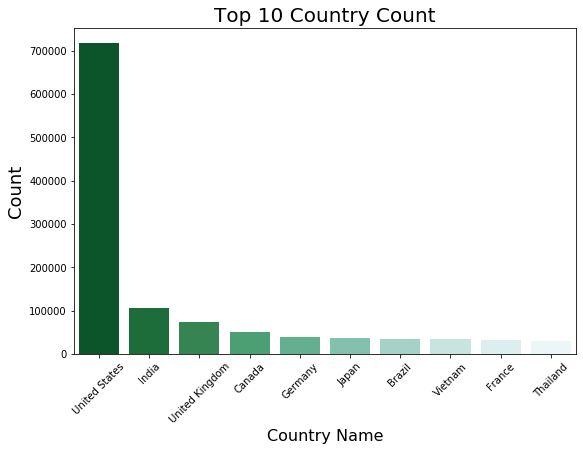

In [34]:
# Top 10 Country Count
plt.figure(figsize=(9,6))
country_order = dataNew2["geoNetwork.country"].value_counts()[:10].sort_values(ascending=False).index

sns.countplot(dataNew2["geoNetwork.country"], order=country_order, palette='BuGn_r')
plt.title("Top 10 Country Count", fontsize=20) # seting the title size
plt.xlabel("Country Name", fontsize=16) # seting the x label size
plt.xticks(rotation=45)
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [15]:
# Top 10 Country Count
spark.sql("""SELECT `geoNetwork.country`, COUNT(`geoNetwork.country`) AS Count \
            FROM viewDF \
            GROUP BY `geoNetwork.country` \
            ORDER BY COUNT(`geoNetwork.country`) DESC\
            LIMIT 10""").show()

+------------------+------+
|geoNetwork.country| Count|
+------------------+------+
|     United States|717217|
|             India|105317|
|    United Kingdom| 73341|
|            Canada| 51057|
|           Germany| 38516|
|             Japan| 36637|
|            Brazil| 35432|
|           Vietnam| 34869|
|            France| 32289|
|          Thailand| 29859|
+------------------+------+



Top 10 countries that users come from are United States, India, United Kingdom, Canada, Vietnam, Turkey, Thailand, Germany, Brazil, and Japan

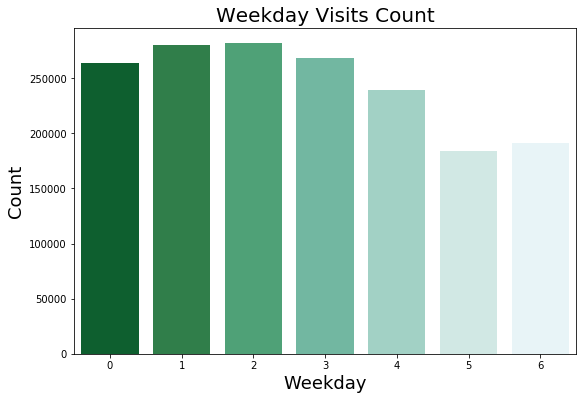

In [35]:
# Weekday Visits Count
plt.figure(figsize=(9,6))

sns.countplot(dataNew2["weekday"], palette='BuGn_r')
plt.title("Weekday Visits Count", fontsize=20) # seting the title size
plt.xlabel("Weekday", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [16]:
# Weekday Visits Count
spark.sql("""SELECT weekday, COUNT(weekday) AS Count \
            FROM viewDF \
            GROUP BY weekday \
            ORDER BY weekday\
            LIMIT 7""").show()

+-------+------+
|weekday| Count|
+-------+------+
|      0|264168|
|      1|279675|
|      2|281701|
|      3|268463|
|      4|239216|
|      5|183999|
|      6|191115|
+-------+------+



Monday, Tuesday,  Wednesday are top 3 weekdays that have the most vist. Surprisingly, weekends contributed the least visits. 

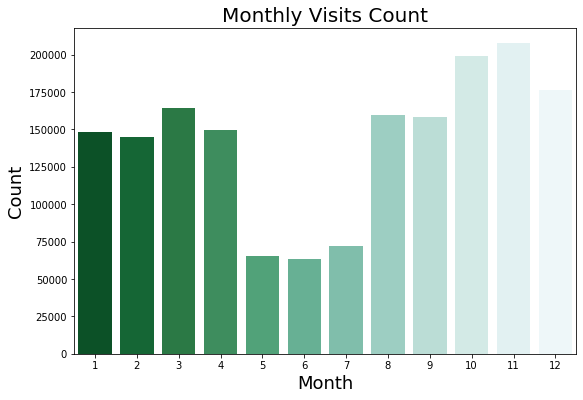

In [36]:
#Monthly Visits Count
plt.figure(figsize=(9,6))

sns.countplot(dataNew2["month"], palette='BuGn_r')
plt.title("Monthly Visits Count", fontsize=20) # seting the title size
plt.xlabel("Month", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size

plt.show()

In [17]:
# Monthly Visits Count
spark.sql("""SELECT month, COUNT(month) AS Count \
            FROM viewDF \
            GROUP BY month \
            ORDER BY month\
            LIMIT 12""").show()

+-----+------+
|month| Count|
+-----+------+
|    1|148084|
|    2|145196|
|    3|164020|
|    4|149727|
|    5| 65371|
|    6| 63578|
|    7| 71812|
|    8|159561|
|    9|158307|
|   10|198792|
|   11|207661|
|   12|176228|
+-----+------+



October and November have the most visits, while May, June, and July have the least.

### Transactions

In [37]:
# Find number of rows that totals.transactionRevenue is nonzero
np.count_nonzero(dataNew2["totals.transactionRevenue"])

18514

In [38]:
# Find the ratio of nonzero rows above the entire dataset
nz_revenue= np.count_nonzero(dataNew2["totals.transactionRevenue"])
print(f"The number of non-zero transaction is {nz_revenue} \nThe ratio is {nz_revenue/dataNew2.shape[0]}")

The number of non-zero transaction is 18514 
The ratio is 0.010837440153786987


In [39]:
nz_revenue_df = dataNew2.loc[dataNew2["totals.transactionRevenue"]>0] #create a new df with only non-zero transactions
nz_revenue_df.head(5)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,totals.pageviews,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,weekday,day,month,year,visitHour
433,Organic Search,2017-10-16,9549826748224805897,1508200705,4,1508200705,Chrome,Macintosh,False,desktop,...,9.0,15190000.0,(not set),google,organic,0,16,10,2017,20
550,Referral,2017-10-16,3700714855829972615,1508192636,11,1508192636,Chrome,Windows,False,desktop,...,12.0,8000000.0,(not set),(direct),(none),0,16,10,2017,18
555,Organic Search,2017-10-16,1572225825161580042,1508162218,6,1508162218,Safari,iOS,True,mobile,...,15.0,57300000.0,(not set),google,organic,0,16,10,2017,9
597,Referral,2017-10-16,7187192533100162289,1508189401,17,1508189401,Chrome,Macintosh,False,desktop,...,16.0,18230000.0,(not set),(direct),(none),0,16,10,2017,17
619,Referral,2017-10-16,7889233516776348524,1508190484,1,1508190484,Chrome,Macintosh,False,desktop,...,20.0,12310000.0,(not set),(direct),(none),0,16,10,2017,17


In [40]:
nz_revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18514 entries, 433 to 1708001
Data columns (total 28 columns):
channelGrouping              18514 non-null object
date                         18514 non-null datetime64[ns]
fullVisitorId                18514 non-null object
visitId                      18514 non-null int64
visitNumber                  18514 non-null int64
visitStartTime               18514 non-null int64
device.browser               18514 non-null object
device.operatingSystem       18514 non-null object
device.isMobile              18514 non-null bool
device.deviceCategory        18514 non-null object
geoNetwork.continent         18514 non-null object
geoNetwork.subContinent      18514 non-null object
geoNetwork.country           18514 non-null object
geoNetwork.region            18514 non-null object
geoNetwork.metro             18514 non-null object
geoNetwork.city              18514 non-null object
geoNetwork.networkDomain     18514 non-null object
totals.hits      

### Total Hits

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.show(*args, **kw)>

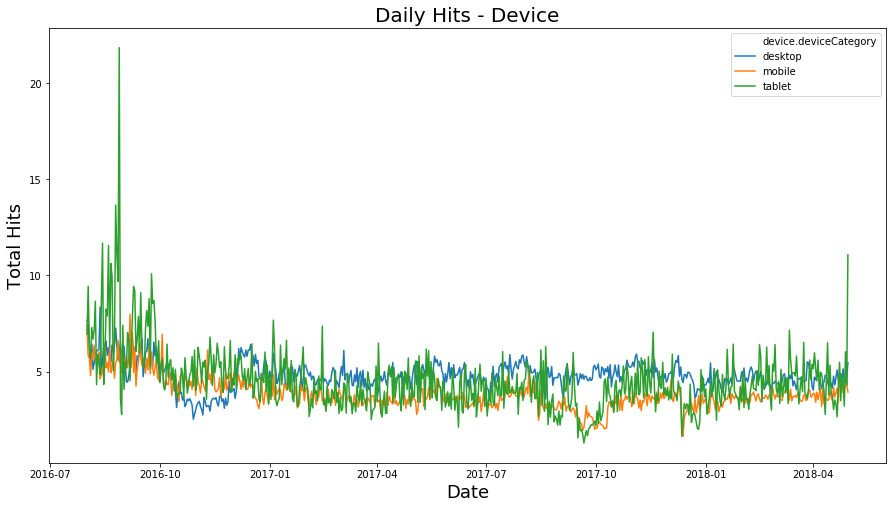

In [41]:
# Daily Hits
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="totals.hits", data=dataNew2, ci=None, hue="device.deviceCategory")
plt.title("Daily Hits - Device", fontsize=20)
plt.xlabel("Date", fontsize=18) 
plt.ylabel("Total Hits", fontsize=18)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

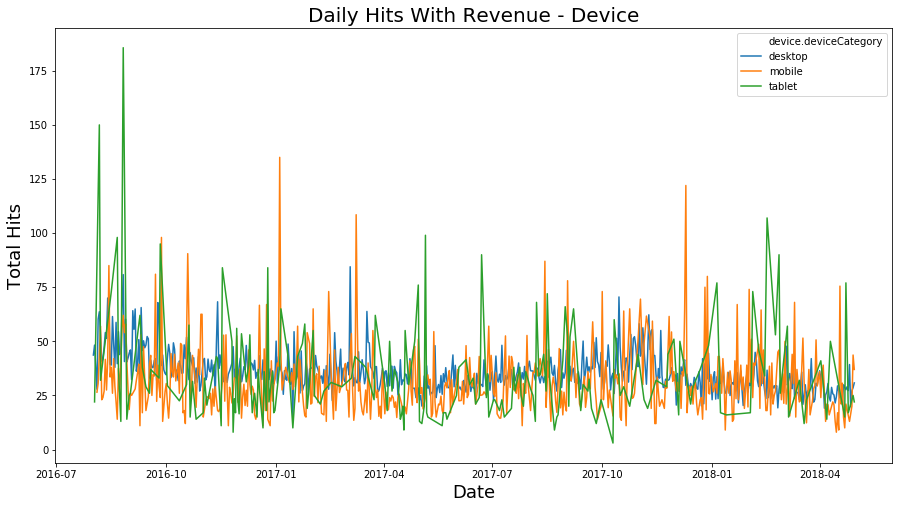

In [42]:
# Total Hits Across the Date with Nonzero Revenue
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="totals.hits", data=nz_revenue_df, ci=None, hue="device.deviceCategory")
plt.title("Daily Hits With Revenue - Device", fontsize=20)
plt.xlabel("Date", fontsize=18) 
plt.ylabel("Total Hits", fontsize=18)
plt.show

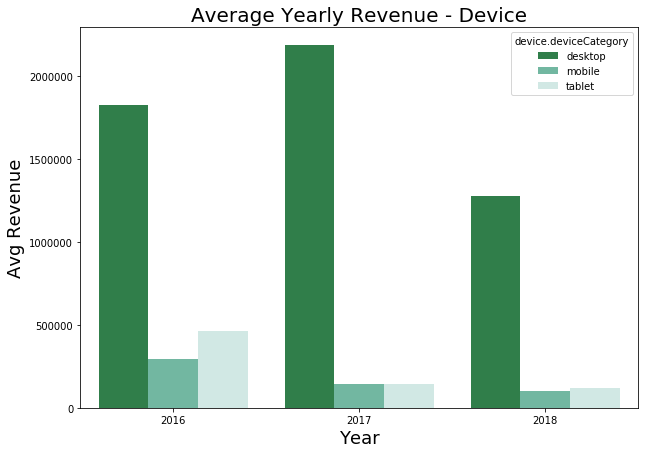

In [43]:
# Average Yearly Revenue - Device
plt.figure(figsize=(10,7))

sns.barplot(x="year", y="totals.transactionRevenue", hue="device.deviceCategory", data=dataNew2, palette='BuGn_r', ci=None)
plt.title("Average Yearly Revenue - Device", fontsize=20) # seting the title size
plt.xlabel("Year", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

In [18]:
# Average Yearly Revenue - Device
spark.sql("""SELECT year, `device.deviceCategory`, FLOOR(AVG(`totals.transactionRevenue`)) as AvgRevenue \
             FROM viewDF \
             GROUP BY `device.deviceCategory`, year\
             ORDER BY year, AVG(`totals.transactionRevenue`) DESC
             """).show()

+----+---------------------+----------+
|year|device.deviceCategory|AvgRevenue|
+----+---------------------+----------+
|2016|              desktop|   1830041|
|2016|               tablet|    465511|
|2016|               mobile|    293851|
|2017|              desktop|   2186818|
|2017|               tablet|    143851|
|2017|               mobile|    141721|
|2018|              desktop|   1280623|
|2018|               tablet|    118704|
|2018|               mobile|    103669|
+----+---------------------+----------+



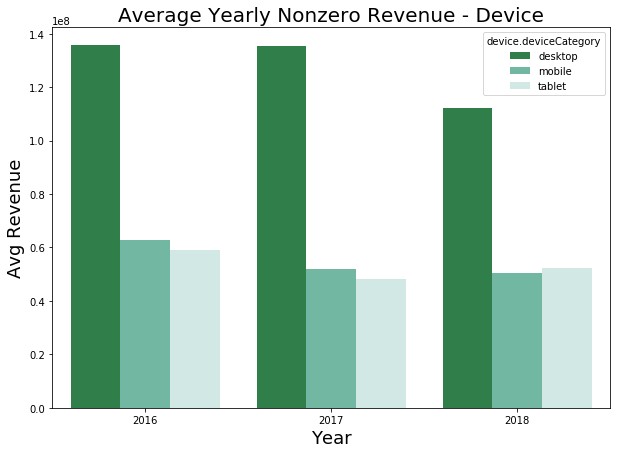

In [44]:
# Average Yearly Nonzero Revenue - Device
plt.figure(figsize=(10,7))

sns.barplot(x="year", y="totals.transactionRevenue", hue="device.deviceCategory", data=nz_revenue_df, palette='BuGn_r', ci=None)
plt.title("Average Yearly Nonzero Revenue - Device", fontsize=20) # seting the title size
plt.xlabel("Year", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

In [19]:
# Average Yearly Nonzero Revenue - Device
spark.sql("""SELECT year, `device.deviceCategory`, FLOOR(AVG(`totals.transactionRevenue`)) as AvgRevenue \
             FROM viewDF \
             WHERE `totals.transactionRevenue` > 0 \
             GROUP BY `device.deviceCategory`, year \
             ORDER BY year, AvgRevenue DESC
             """).show()

+----+---------------------+----------+
|year|device.deviceCategory|AvgRevenue|
+----+---------------------+----------+
|2016|              desktop| 135585123|
|2016|               mobile|  62890200|
|2016|               tablet|  59070425|
|2017|              desktop| 135473402|
|2017|               mobile|  51893089|
|2017|               tablet|  48277177|
|2018|              desktop| 112012600|
|2018|               tablet|  52225555|
|2018|               mobile|  50354784|
+----+---------------------+----------+



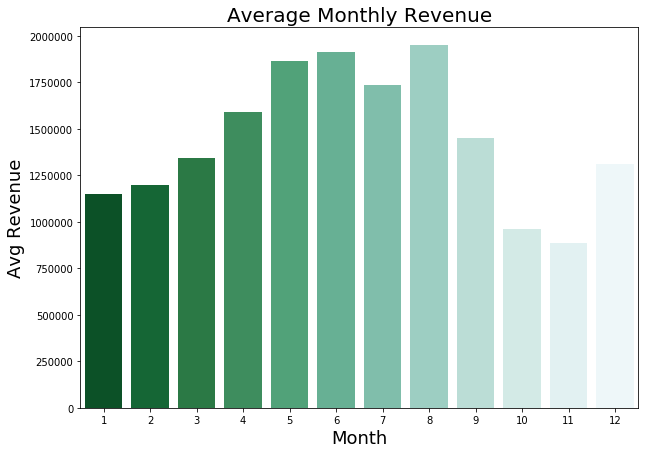

In [46]:
#Average Monthly Revenue
plt.figure(figsize=(10,7))

sns.barplot(x="month", y="totals.transactionRevenue", data=dataNew2, palette='BuGn_r', ci=None)
plt.title("Average Monthly Revenue", fontsize=20) # seting the title size
plt.xlabel("Month", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

In [20]:
# Average Monthly Revenue
spark.sql("""SELECT month, FLOOR(AVG(`totals.transactionRevenue`)) as AvgRevenue \
             FROM viewDF \
             GROUP BY month \
             ORDER BY AVG(`totals.transactionRevenue`) DESC """).show()

+-----+----------+
|month|AvgRevenue|
+-----+----------+
|    8|   1947741|
|    6|   1912131|
|    5|   1861857|
|    7|   1733683|
|    4|   1591049|
|    9|   1449312|
|    3|   1343003|
|   12|   1309044|
|    2|   1196653|
|    1|   1149448|
|   10|    960168|
|   11|    887571|
+-----+----------+



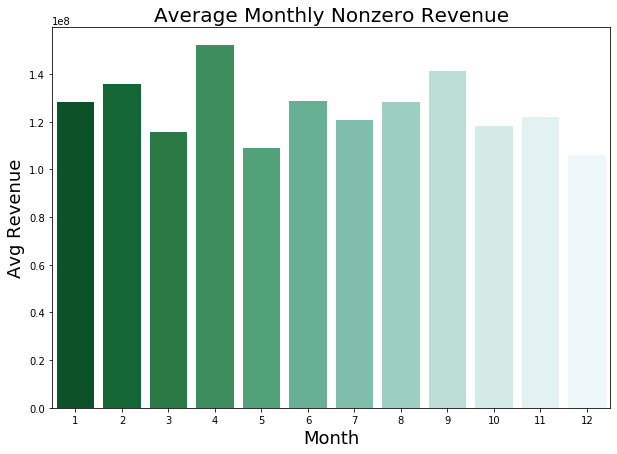

In [47]:
# Average Monthly Nonzero Revenue
plt.figure(figsize=(10,7))

sns.barplot(x="month", y="totals.transactionRevenue", data=nz_revenue_df, palette='BuGn_r', ci=None)
plt.title("Average Monthly Nonzero Revenue", fontsize=20) # seting the title size
plt.xlabel("Month", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

In [21]:
# Average Monthly Nonzero Revenue
spark.sql("""SELECT month, FLOOR(AVG(`totals.transactionRevenue`)) as AvgRevenue \
             FROM viewDF \
             WHERE `totals.transactionRevenue` > 0 \
             GROUP BY month \
             ORDER BY AVG(`totals.transactionRevenue`) DESC """).show()

+-----+----------+
|month|AvgRevenue|
+-----+----------+
|    4| 152024952|
|    9| 141104784|
|    2| 135954100|
|    6| 128508974|
|    1| 128367164|
|    8| 128316907|
|   11| 122062211|
|    7| 120755848|
|   10| 118408114|
|    3| 115510964|
|    5| 109158278|
|   12| 106113279|
+-----+----------+



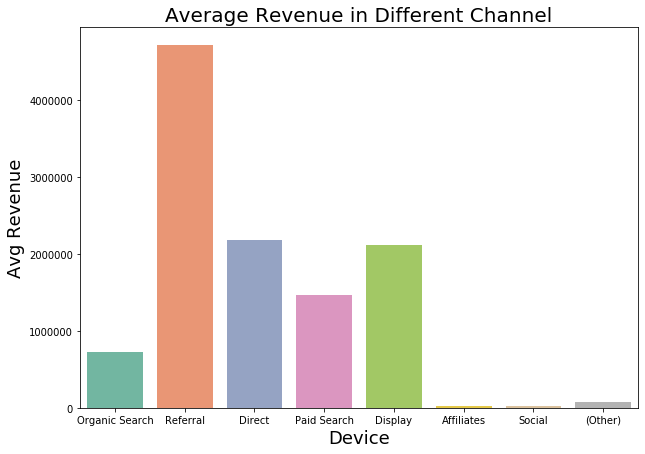

In [52]:
#Average Revenue in Different Channel
plt.figure(figsize=(10,7))

sns.barplot(x="channelGrouping", y="totals.transactionRevenue", data=dataNew2, palette='Set2', ci=None)
plt.title("Average Revenue in Different Channel", fontsize=20) # seting the title size
plt.xlabel("Device", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

In [22]:
# Average Revenue in Different Channel
spark.sql("""SELECT `channelGrouping`,  FLOOR(AVG(`totals.transactionRevenue`)) as AvgRevenue, \
            FLOOR(Sum(`totals.transactionRevenue`)) as TotalRev, COUNT(`channelGrouping`) as Count
            FROM viewDF
            GROUP BY `channelGrouping`
            ORDER BY AVG(`totals.transactionRevenue`) DESC """).show()

+---------------+----------+------------+------+
|channelGrouping|AvgRevenue|    TotalRev| Count|
+---------------+----------+------------+------+
|       Referral|   4713620|996021010000|211307|
|         Direct|   2186927|597324310000|273134|
|        Display|   2111601|108289260000| 51283|
|    Paid Search|   1467741| 66968620000| 45627|
| Organic Search|    730075|539498950000|738963|
|        (Other)|     72919|     9990000|   137|
|     Affiliates|     26281|   865070000| 32915|
|         Social|     20755|  7367770000|354971|
+---------------+----------+------------+------+



In [23]:
spark.sql("""SELECT `channelGrouping`,  COUNT(`channelGrouping`) as CountChannel, 
            ROUND(COUNT(`channelGrouping`)/1708337, 2) as Ratio
            FROM viewDF
            GROUP BY `channelGrouping`
            ORDER BY Ratio DESC """).show()

+---------------+------------+-----+
|channelGrouping|CountChannel|Ratio|
+---------------+------------+-----+
| Organic Search|      738963| 0.43|
|         Social|      354971| 0.21|
|         Direct|      273134| 0.16|
|       Referral|      211307| 0.12|
|        Display|       51283| 0.03|
|    Paid Search|       45627| 0.03|
|     Affiliates|       32915| 0.02|
|        (Other)|         137|  0.0|
+---------------+------------+-----+



In [24]:
# To calculate the ratio
spark.sql(""" SELECT FLOOR(SUM(`totals.transactionRevenue`)) as TotalReveue
            FROM viewDF """).show()

#Referral
print("Referral: ", 996021010000/2316344980000)

#Direct
print("Direct: ", 597324310000/2316344980000)

#Display
print("Display: ", 108289260000/2316344980000)

#Organic 
print("Organic: ", 539498950000/2316344980000)

+-------------+
|  TotalReveue|
+-------------+
|2316344980000|
+-------------+

Referral:  0.42999683492741225
Direct:  0.2578736393574674
Display:  0.046750057066197455
Organic:  0.23290958585970212


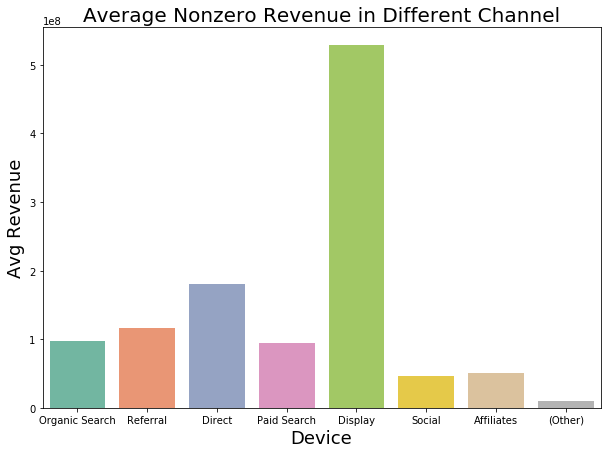

In [53]:
# Average Nonzero Revenue in Different Channel
plt.figure(figsize=(10,7))

sns.barplot(x="channelGrouping", y="totals.transactionRevenue",data=nz_revenue_df, palette='Set2', ci=None)
plt.title("Average Nonzero Revenue in Different Channel", fontsize=20) # seting the title size
plt.xlabel("Device", fontsize=18) # seting the x label size
plt.ylabel("Avg Revenue", fontsize=18) # seting the y label size

plt.show()

In [25]:
# Average Nonzero Revenue in Different Channel
spark.sql("""SELECT `channelGrouping`,  FLOOR(AVG(`totals.transactionRevenue`)) as AvgRevenue, \
            FLOOR(Sum(`totals.transactionRevenue`)) as TotalRev, COUNT(`channelGrouping`) as Count
            FROM viewDF
            WHERE `totals.transactionRevenue` > 0
            GROUP BY `channelGrouping`
            ORDER BY AVG(`totals.transactionRevenue`) DESC """).show()

+---------------+----------+------------+-----+
|channelGrouping|AvgRevenue|    TotalRev|Count|
+---------------+----------+------------+-----+
|        Display| 528240292|108289260000|  205|
|         Direct| 179916960|597324310000| 3320|
|       Referral| 116005242|996021010000| 8586|
| Organic Search|  97859414|539498950000| 5513|
|    Paid Search|  94189338| 66968620000|  711|
|     Affiliates|  50886470|   865070000|   17|
|         Social|  45762546|  7367770000|  161|
|        (Other)|   9990000|     9990000|    1|
+---------------+----------+------------+-----+



## Model

In [26]:
# Load Data
df_nz = pd.read_csv("s3://largedataset-project/nz_revenue.csv")

### Model Building
* We want to predict whether the total transaction revenue is high or low?
* Also, we want to predict whether a visitor will make transaction?

Before building the model, we first look at the correlation between variables in the dataset by removing non-numerical columns and plot the correlation matrix.

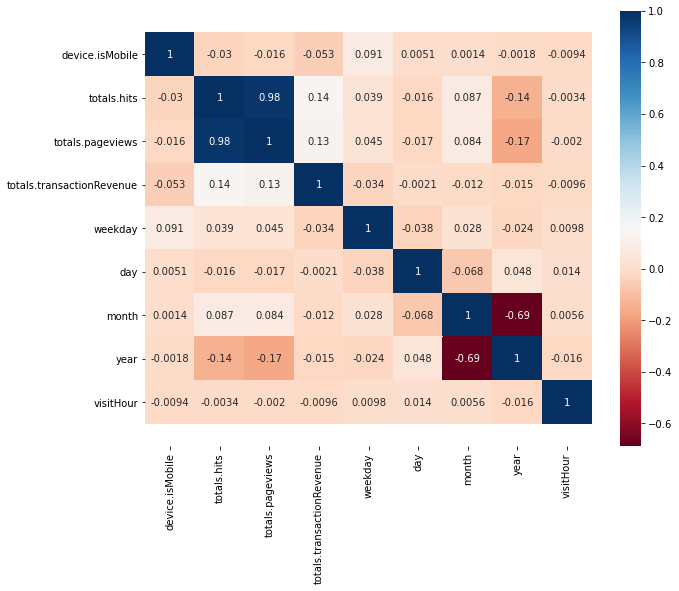

In [27]:
df = df_nz[["device.isMobile", "totals.hits", "totals.pageviews", "totals.transactionRevenue", "weekday", "day", "month", "year", "visitHour"]]
plt.figure(figsize=(10,8))
corrMatrix = df.corr()
ax = sns.heatmap(corrMatrix, annot=True, fmt='.2g', cmap= 'RdBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

From the above correlation matrix, we can see that only total hits and total pageviews have relatively significant positive correlation with total transaction revenue. Moreover, totoal hits and total pageviews seem to be highly correlated with each others.

### Predict Total Transaction Revenue

In this part, we apply random forest classifier to predict the total transaction revenue level for each visitor. Here we define the total transaction revenue into three levels, "High", "Mid", and "Low", based on the statistics quantile.

##### Data Wrangling and Processing

In [28]:
df_nz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18514 entries, 0 to 18513
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   channelGrouping            18514 non-null  object 
 1   date                       18514 non-null  object 
 2   fullVisitorId              18514 non-null  uint64 
 3   visitId                    18514 non-null  int64  
 4   visitNumber                18514 non-null  int64  
 5   visitStartTime             18514 non-null  int64  
 6   device.browser             18514 non-null  object 
 7   device.operatingSystem     18514 non-null  object 
 8   device.isMobile            18514 non-null  bool   
 9   device.deviceCategory      18514 non-null  object 
 10  geoNetwork.continent       18514 non-null  object 
 11  geoNetwork.subContinent    18514 non-null  object 
 12  geoNetwork.country         18514 non-null  object 
 13  geoNetwork.region          18514 non-null  obj

In [29]:
# Deal with date data
df_nz['date'] = pd.to_datetime(df_nz['date'])

In [30]:
# Check the statistics of totals.transactionRevenue
df_nz["totals.transactionRevenue"].describe()

count    1.851400e+04
mean     1.251132e+08
std      4.162653e+08
min      1.000000e+04
25%      2.306750e+07
50%      4.606000e+07
75%      1.000000e+08
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

In [31]:
# Create a new column called 'revenue' as predicted target in the model
# High revenue means the total transaction revenue is higher than 75% quantile, which is 107,740,000
# Low revenue means the total transaction revenue is lower than 25% quantile, which is 24,930,000
# Mid revenue means the total transaction revenue is in between 25% to 75% quantile
df_nz['revenue_high'] = df_nz["totals.transactionRevenue"].apply(lambda x: 1 if x >1.076550e+08 else 0)
df_nz['revenue_mid'] = df_nz["totals.transactionRevenue"].apply(lambda x: 1 if (x >2.493000e+07)and (x <1.076550e+08) else 0)
df_nz['revenue_low'] = df_nz["totals.transactionRevenue"].apply(lambda x: 1 if x <2.493000e+07 else 0)

In [32]:
df_nz.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,trafficSource.source,trafficSource.medium,weekday,day,month,year,visitHour,revenue_high,revenue_mid,revenue_low
0,Organic Search,2017-10-16,9549826748224805897,1508200705,4,1508200705,Chrome,Macintosh,False,desktop,...,google,organic,0,16,10,2017,20,0,0,1
1,Referral,2017-10-16,3700714855829972615,1508192636,11,1508192636,Chrome,Windows,False,desktop,...,(direct),(none),0,16,10,2017,18,0,0,1
2,Organic Search,2017-10-16,1572225825161580042,1508162218,6,1508162218,Safari,iOS,True,mobile,...,google,organic,0,16,10,2017,9,0,1,0
3,Referral,2017-10-16,7187192533100162289,1508189401,17,1508189401,Chrome,Macintosh,False,desktop,...,(direct),(none),0,16,10,2017,17,0,0,1
4,Referral,2017-10-16,7889233516776348524,1508190484,1,1508190484,Chrome,Macintosh,False,desktop,...,(direct),(none),0,16,10,2017,17,0,0,1


In [33]:
list(df_nz.columns)

['channelGrouping',
 'date',
 'fullVisitorId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device.browser',
 'device.operatingSystem',
 'device.isMobile',
 'device.deviceCategory',
 'geoNetwork.continent',
 'geoNetwork.subContinent',
 'geoNetwork.country',
 'geoNetwork.region',
 'geoNetwork.metro',
 'geoNetwork.city',
 'geoNetwork.networkDomain',
 'totals.hits',
 'totals.pageviews',
 'totals.transactionRevenue',
 'trafficSource.campaign',
 'trafficSource.source',
 'trafficSource.medium',
 'weekday',
 'day',
 'month',
 'year',
 'visitHour',
 'revenue_high',
 'revenue_mid',
 'revenue_low']

In [34]:
# Drop columns that will not be used in the model
df_nz = df_nz.drop(["date", "fullVisitorId", "visitId", "visitStartTime", 
                      "geoNetwork.continent", "geoNetwork.subContinent",
                        "geoNetwork.region", "geoNetwork.metro", 
                        "geoNetwork.city", "geoNetwork.networkDomain", 
                        "month", "weekday", "day", "year"], axis = 1)

In [35]:
# Deal with boolean value
df_nz['device.isMobile'] = (df_nz['device.isMobile'] == 'True').astype(int)

/home/hadoop/miniconda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [36]:
df_nz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18514 entries, 0 to 18513
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   channelGrouping            18514 non-null  object 
 1   visitNumber                18514 non-null  int64  
 2   device.browser             18514 non-null  object 
 3   device.operatingSystem     18514 non-null  object 
 4   device.isMobile            18514 non-null  int64  
 5   device.deviceCategory      18514 non-null  object 
 6   geoNetwork.country         18514 non-null  object 
 7   totals.hits                18514 non-null  float64
 8   totals.pageviews           18514 non-null  float64
 9   totals.transactionRevenue  18514 non-null  float64
 10  trafficSource.campaign     18514 non-null  object 
 11  trafficSource.source       18514 non-null  object 
 12  trafficSource.medium       18514 non-null  object 
 13  visitHour                  18514 non-null  int

In [37]:
# Label encoding the Categorical variables
from sklearn.preprocessing import LabelEncoder

categorical_columns = ["channelGrouping", "device.browser", "device.operatingSystem", 
                       "geoNetwork.country", "device.deviceCategory",
                        "trafficSource.campaign", "trafficSource.source","trafficSource.medium"]

le = LabelEncoder()
for col in categorical_columns:
    encoded_col  = list(df_nz[col].values.astype(str))
    le.fit(encoded_col)
    df_nz[col] = le.transform(encoded_col)

##### Model Preparation

In [38]:
# Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn import tree, metrics

In [39]:
ml = df_nz

In [40]:
ml_df = ml.drop(['totals.transactionRevenue'], axis = 1)
X = ml_df.drop(['revenue_high', 'revenue_mid', 'revenue_low'], axis = 1)
y = ml_df[['revenue_high', 'revenue_mid', 'revenue_low']]

In [41]:
# Create a train-test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12959 entries, 5720 to 17673
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   channelGrouping         12959 non-null  int64  
 1   visitNumber             12959 non-null  int64  
 2   device.browser          12959 non-null  int64  
 3   device.operatingSystem  12959 non-null  int64  
 4   device.isMobile         12959 non-null  int64  
 5   device.deviceCategory   12959 non-null  int64  
 6   geoNetwork.country      12959 non-null  int64  
 7   totals.hits             12959 non-null  float64
 8   totals.pageviews        12959 non-null  float64
 9   trafficSource.campaign  12959 non-null  int64  
 10  trafficSource.source    12959 non-null  int64  
 11  trafficSource.medium    12959 non-null  int64  
 12  visitHour               12959 non-null  int64  
dtypes: float64(2), int64(11)
memory usage: 1.4 MB


##### Apply Random Forest and XGBoost Classifier

In [43]:
!pip install xgboost

In [44]:
# Import Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from xgboost import plot_tree

In [45]:
df_nz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18514 entries, 0 to 18513
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   channelGrouping            18514 non-null  int64  
 1   visitNumber                18514 non-null  int64  
 2   device.browser             18514 non-null  int64  
 3   device.operatingSystem     18514 non-null  int64  
 4   device.isMobile            18514 non-null  int64  
 5   device.deviceCategory      18514 non-null  int64  
 6   geoNetwork.country         18514 non-null  int64  
 7   totals.hits                18514 non-null  float64
 8   totals.pageviews           18514 non-null  float64
 9   totals.transactionRevenue  18514 non-null  float64
 10  trafficSource.campaign     18514 non-null  int64  
 11  trafficSource.source       18514 non-null  int64  
 12  trafficSource.medium       18514 non-null  int64  
 13  visitHour                  18514 non-null  int

In [46]:
# Create a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=10)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=10)

In [47]:
# Testing Accuracy
y_pred = rf_model.predict(X_test)
print(accuracy_score(y_test.values.argmax(axis = 1), y_pred.argmax(axis = 1)))

0.4496849684968497


In [48]:
# Create a XGBoost Classifier
xgb_model = XGBClassifier(learning_rate =0.01, n_estimators=500, max_depth=5, 
                          objective= 'multi:softmax', num_class=3, seed=27)
xgb_model.fit(X_train, np.argmax(y_train.to_numpy(), axis = 1))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=27, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
# Testing Accuracy
y_pred = xgb_model.predict(X_test)
print(classification_report(np.argmax(y_test.to_numpy(), axis = 1),y_pred))
print("Accuracy of Testing Data:",metrics.accuracy_score(np.argmax(y_test.to_numpy(), axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.59      0.25      0.35      1280
           1       0.53      0.87      0.66      2760
           2       0.57      0.20      0.29      1515

    accuracy                           0.54      5555
   macro avg       0.56      0.44      0.43      5555
weighted avg       0.56      0.54      0.49      5555

Accuracy of Testing Data: 0.5416741674167417


In [51]:
# conda install python-graphviz

In [52]:
# # Plot Tree
# plot_tree(xgb_model, num_trees=5, rankdir='LR')
# plt.show()

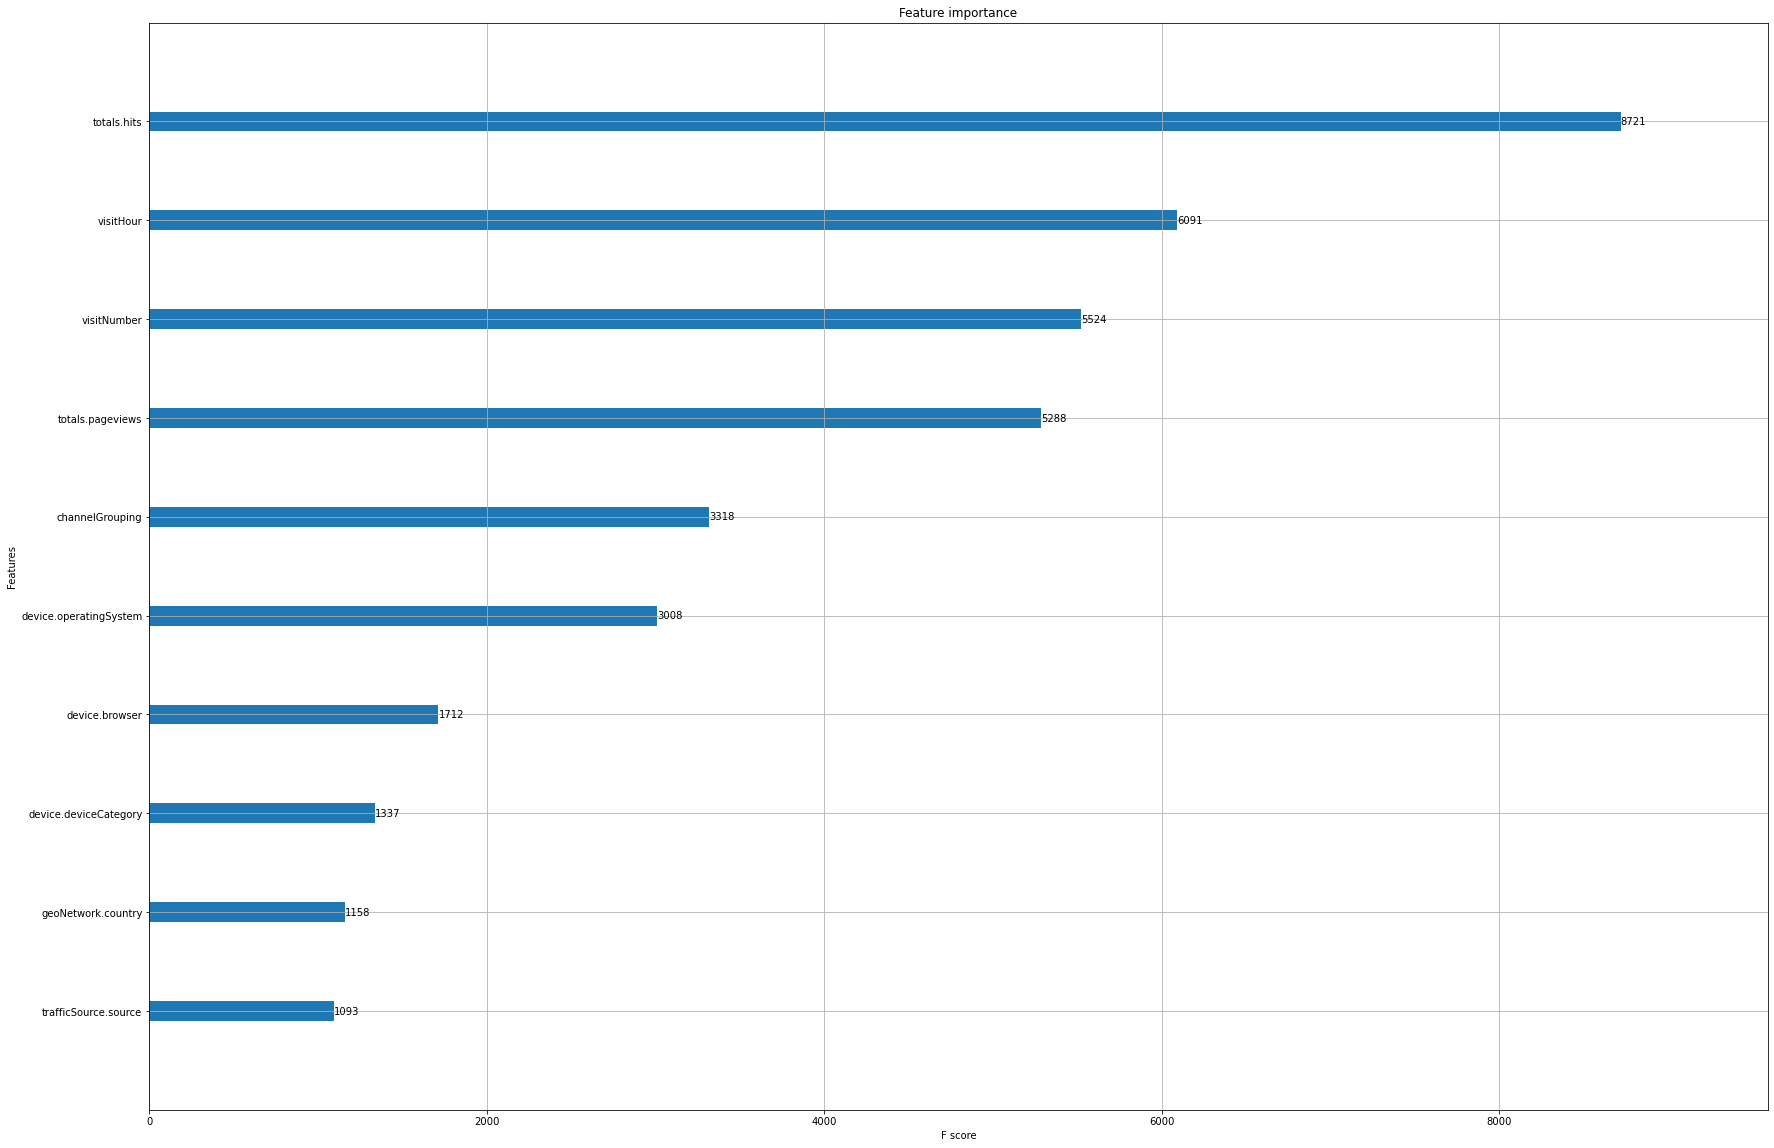

In [53]:
# Plot Feature Importance
plt.rcParams["figure.figsize"] = (29, 20)
plot_importance(xgb_model, max_num_features=10)

From the above results, we can see that total hits, visit hour and total pageviews are the top 3 important features when predicting the visitor's total transaction revenue. Whether the visit is the first session is also an important element when predicting. Therefore, in below we would like to explore more about the relationship between total transaction revenue and total hits, visit hour and visit number.

In [54]:
# Create a new column called 'first_session'
df_nz['first_session'] = df_nz["visitNumber"].apply(lambda x: 0 if x > 1 else 1)
# Create a new column called 'revenue'
def conditions(df):
    if (df['totals.transactionRevenue'] > 1.076550e+08):
        return 3
    elif (df['totals.transactionRevenue'] < 2.493000e+07):
        return 1
    else:
        return 2
df_nz['revenue'] = df_nz.apply(conditions, axis=1)

Text(0.5, 1.0, 'Total Hits v.s. Frequency')

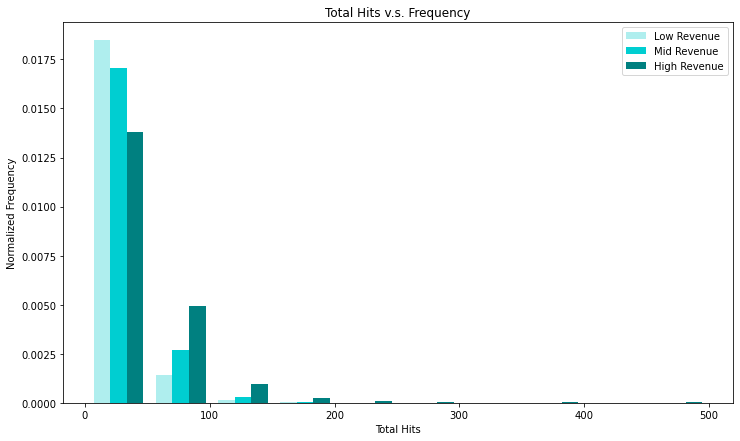

In [55]:
# Total Hits vs Frequency
fig = plt.figure(figsize=(12, 7))
x1 = list(df_nz[df_nz.revenue == 1]['totals.hits'])
x2 = list(df_nz[df_nz.revenue == 2]['totals.hits'])
x3 = list(df_nz[df_nz.revenue == 3]['totals.hits'])

# Assign colors for each labels and the names
colors = ['paleturquoise', 'darkturquoise', 'teal']
names = ['Low Revenue', 'Mid Revenue', 'High Revenue']
         
# Make the histogram using a list of lists
# Normalize the frequency and assign colors and names
plt.hist([x1, x2, x3], density = 1, color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Total Hits')
plt.ylabel('Normalized Frequency')
plt.title('Total Hits v.s. Frequency')

From the above graph, we can see that majority of the visitors in three revenue group have total hits between range of 0 and 100. Moreover, most of the visitors whose transaction revenue is low have the lowest total hits. As for the visitors who spent high total revenue on the website, some of their total hits seem to be relatively high comparing to the other two groups.

Text(0.5, 1.0, 'Visit Hours v.s. Frequency')

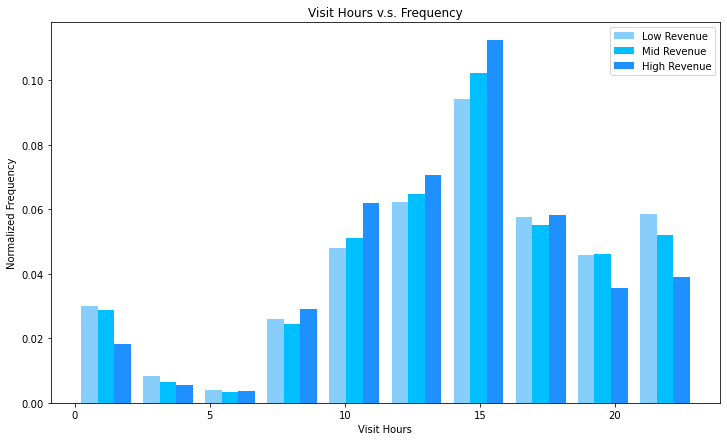

In [56]:
# Visit Hours vs Frequency
fig = plt.figure(figsize=(12, 7))
x1 = list(df_nz[df_nz.revenue == 1]['visitHour'])
x2 = list(df_nz[df_nz.revenue == 2]['visitHour'])
x3 = list(df_nz[df_nz.revenue == 3]['visitHour'])

# Assign colors for each labels and the names
colors = ['lightskyblue', 'deepskyblue', 'dodgerblue']
names = ['Low Revenue', 'Mid Revenue', 'High Revenue']
         
# Make the histogram using a list of lists
# Normalize the frequency and assign colors and names
plt.hist([x1, x2, x3], density = 1, color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Visit Hours')
plt.ylabel('Normalized Frequency')
plt.title('Visit Hours v.s. Frequency')

In [57]:
df_nz['visitHour'].describe()

count    18514.000000
mean        14.138274
std          5.422704
min          0.000000
25%         11.000000
50%         15.000000
75%         18.000000
max         23.000000
Name: visitHour, dtype: float64

From the above graph, we can see that the distribution of the visit hours seems to be biopolar, only a few have visit hours around 10 hours. When the visit hours are low, less than 5 hours, visitors tend to spend lower. The reason of this might be, when people tend to buy low-price items on the website, they don't need to hesitate for a long time. On the other hand, when the visit hours are high, more than 10 hours, the majority og visitors spend higher. It is reasonable since most of the people would think twice and browsing around the website before buying expensive items. There is an interesting part of the graph, for the visit hours are higher than 20 hours, visitors whose transaction revenue is low seem to be the majority among three groups.

NameError: name 'mpatches' is not defined

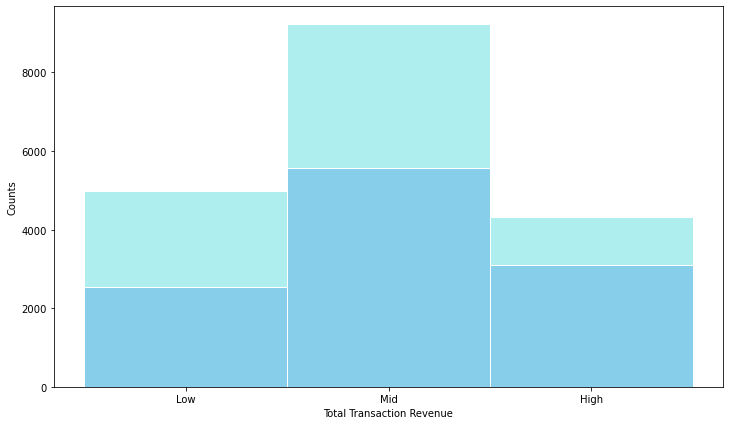

In [58]:
# Revenue v.s. First Session
fig = plt.figure(figsize=(12,7))
revenue_level = [1,2,3]
x1 = []
for i in range(1,4,1):
    x1.append(len(df_nz[(df_nz['first_session'] == 0) & (df_nz['revenue'] == i)]))
    
x2 = []
for i in range(1,4,1):
    x2.append(len(df_nz[(df_nz['first_session'] == 1) & (df_nz['revenue'] == i)]))

# Assign colors and the names
colors = ['skyblue', 'lightcoral']
names = ['Not First Session', 'First Session']

# Names of group and bar width
names = ['Low','Mid','High']
barWidth = 1
         
# Create lower bars
plt.bar(revenue_level, x1, color='skyblue', edgecolor='white', width=barWidth)
# Create upper bars, on top of the first ones
plt.bar(revenue_level, x2, bottom=x1, color='paleturquoise', edgecolor='white', width=barWidth)


# Plot formatting
plt.xticks(revenue_level, names)
plt.xlabel("Total Transaction Revenue")
plt.ylabel('Counts')
blue_patch = mpatches.Patch(color='skyblue', label='Not First Session')
pink_patch = mpatches.Patch(color='paleturquoise', label='First Session')
plt.legend(handles=[blue_patch, pink_patch])
plt.title('Total Transaction Revenue v.s. First Session')

From the above graph, we can see that among the low transaction revenue group, visitor are in the first session and visitors are not in the first seem to be 50% and 50%. On the other hand, among the mid and high transaction revenue groups, majority of the visitors are not in the first session. It might because visitors who spend more have already been through the website before or have already browsing around the website many time before making transaction.

### Try in Pyspark

##### Data Wrangling and Processing

In [60]:
# Load data
df_ml = spark.read\
    .format('csv')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .load('s3://largedataset-project/nz_revenue.csv')

In [61]:
# Rename columns with dot to prevent system error in the further machine learning process
import re
df_ml = df_ml.toDF(*(re.sub(r'[\.\s]+', '_', c) for c in df_ml.columns))

In [62]:
df_ml.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- fullVisitorId: decimal(19,0) (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- visitStartTime: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: boolean (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_subContinent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- geoNetwork_region: string (nullable = true)
 |-- geoNetwork_metro: string (nullable = true)
 |-- geoNetwork_city: string (nullable = true)
 |-- geoNetwork_networkDomain: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- trafficSource_c

In [63]:
# Drop columns that will not be used for model building
columns_to_drop = ['date', 'fullVisitorId', 'sessionId', 'visitId', 'visitStartTime','geoNetwork_subContinent', 'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city', 'geoNetwork_networkDomain', 'day', 'year']
df_ml_2 = df_ml.drop(*columns_to_drop)

In [64]:
df_ml_2.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: boolean (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- trafficSource_campaign: string (nullable = true)
 |-- trafficSource_source: string (nullable = true)
 |-- trafficSource_medium: string (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- visitHour: integer (nullable = true)



In [65]:
# Deal with boolean type columns
from pyspark.sql.functions import col
df_ml_2 = df_ml_2.withColumn("device_isMobile", df_ml_2["device_isMobile"].cast("integer"))

In [66]:
# Calculate the quantile of total transaction revenue
df_ml_2.approxQuantile('totals_transactionRevenue', [0.25, 0.5, 0.75], 0)

[23060000.0, 46040000.0, 100000000.0]

In [67]:
# Create a new column called 'revenue' as predicted target in the model
# High revenue means the total transaction revenue is higher than 75% quantile, which is 107,740,000
# Low revenue means the total transaction revenue is lower than 25% quantile, which is 24,930,000
# Mid revenue means the total transaction revenue is in between 25% to 75% quantile

from pyspark.sql import functions as F
df_ml_3 = df_ml_2.withColumn(
    'revenue',
    F.when(F.col("totals_transactionRevenue") > 107740000.0, 'High')\
    .when(F.col("totals_transactionRevenue").between(24930000.0,107740000.0), 'Mid')\
    .when(F.col("totals_transactionRevenue") < 24930000.0, 'Low')
)

In [68]:
df_ml_3.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: integer (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- trafficSource_campaign: string (nullable = true)
 |-- trafficSource_source: string (nullable = true)
 |-- trafficSource_medium: string (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- visitHour: integer (nullable = true)
 |-- revenue: string (nullable = true)



In [69]:
# Deal with string columns
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
stringIndexer_channel = StringIndexer(inputCol="channelGrouping", outputCol="channel")
stringIndexer_browser = StringIndexer(inputCol="device_browser", outputCol="browser")
stringIndexer_system = StringIndexer(inputCol="device_operatingSystem", outputCol="system")
stringIndexer_devicetype = StringIndexer(inputCol="device_deviceCategory", outputCol="device_type")
stringIndexer_continent = StringIndexer(inputCol="geoNetwork_continent", outputCol="continent")
stringIndexer_revenue = StringIndexer(inputCol="revenue", outputCol="revenue_level")

In [70]:
revenue_fit = StringIndexer(inputCol="revenue", outputCol="revenue_level").fit(df_ml_3)

In [71]:
revenue_fit.labels

['Mid', 'Low', 'High']

In [72]:
from pyspark.ml import Pipeline
pipeline_string_index = Pipeline(stages=[stringIndexer_channel, 
                               stringIndexer_browser, 
                               stringIndexer_system, 
                               stringIndexer_devicetype, 
                               stringIndexer_continent, stringIndexer_revenue])
df_ml_4 = pipeline_string_index.fit(df_ml_3).transform(df_ml_3)

In [73]:
df_ml_4.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: integer (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- trafficSource_campaign: string (nullable = true)
 |-- trafficSource_source: string (nullable = true)
 |-- trafficSource_medium: string (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- visitHour: integer (nullable = true)
 |-- revenue: string (nullable = true)
 |-- channel: double (nullable = false)
 |-- browser: double (nullable = false)
 |-- system: double (nullable = false)
 |-- device_type:

In [74]:
# Create columns that contains all the features by using vector assembler
vectorAssembler_feature = VectorAssembler(inputCols = ['channel',
                                                       'visitNumber',
                                                       'browser', 
                                                       'system',
                                                       'device_type', 
                                                       'continent',
                                                       'totals_hits', 
                                                       'totals_pageviews', 
                                                       'visitHour'], 
                                          outputCol = 'features')

In [75]:
vectorAssembler_feature 

VectorAssembler_70b8dbb16a98

In [76]:
df_ml_clean = vectorAssembler_feature.transform(df_ml_4)

In [77]:
df_ml_clean.take(3)

[Row(channelGrouping='Organic Search', visitNumber=4, device_browser='Chrome', device_operatingSystem='Macintosh', device_isMobile=0, device_deviceCategory='desktop', geoNetwork_continent='Americas', geoNetwork_country='United States', totals_hits=9.0, totals_pageviews=9.0, totals_transactionRevenue=15190000.0, trafficSource_campaign='(not set)', trafficSource_source='google', trafficSource_medium='organic', weekday=0, month=10, visitHour=20, revenue='Low', channel=1.0, browser=0.0, system=0.0, device_type=0.0, continent=0.0, revenue_level=1.0, features=DenseVector([1.0, 4.0, 0.0, 0.0, 0.0, 0.0, 9.0, 9.0, 20.0])),
 Row(channelGrouping='Referral', visitNumber=11, device_browser='Chrome', device_operatingSystem='Windows', device_isMobile=0, device_deviceCategory='desktop', geoNetwork_continent='Americas', geoNetwork_country='United States', totals_hits=15.0, totals_pageviews=12.0, totals_transactionRevenue=8000000.0, trafficSource_campaign='(not set)', trafficSource_source='(direct)', tr

### Split the dataset to training and test data

In [78]:
split = df_ml_clean.randomSplit([0.7, 0.3], seed = 100)
df_train = split[0].select(['features', 'revenue_level'])
df_test = split[1].select(['features', 'revenue_level'])

In [79]:
df_train.printSchema()

root
 |-- features: vector (nullable = true)
 |-- revenue_level: double (nullable = false)



In [80]:
df_train.show(3)

+--------------------+-------------+
|            features|revenue_level|
+--------------------+-------------+
|[6.0,1.0,0.0,5.0,...|          1.0|
|[6.0,1.0,0.0,0.0,...|          1.0|
|[6.0,1.0,0.0,0.0,...|          2.0|
+--------------------+-------------+
only showing top 3 rows



### Apply Random Forest Classification

In [81]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="revenue_level", featuresCol="features")

In [82]:
rf_model = rf.fit(df_train)

In [83]:
predictions = rf_model.transform(df_test)
predictions.select("prediction", "revenue_level", "features").show(5)

+----------+-------------+--------------------+
|prediction|revenue_level|            features|
+----------+-------------+--------------------+
|       0.0|          1.0|[6.0,1.0,1.0,0.0,...|
|       0.0|          1.0|[6.0,2.0,0.0,0.0,...|
|       0.0|          2.0|[6.0,2.0,0.0,1.0,...|
|       0.0|          2.0|[6.0,2.0,0.0,1.0,...|
|       1.0|          1.0|[2.0,1.0,7.0,5.0,...|
+----------+-------------+--------------------+
only showing top 5 rows



In [84]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluatorRF = MulticlassClassificationEvaluator(labelCol="revenue_level", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)

print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.526191
Test Error = 0.473809


In [85]:
predictions.show(3)

+--------------------+-------------+--------------------+--------------------+----------+
|            features|revenue_level|       rawPrediction|         probability|prediction|
+--------------------+-------------+--------------------+--------------------+----------+
|[6.0,1.0,1.0,0.0,...|          1.0|[9.25537098796497...|[0.46276854939824...|       0.0|
|[6.0,2.0,0.0,0.0,...|          1.0|[10.6301176135365...|[0.53150588067682...|       0.0|
|[6.0,2.0,0.0,1.0,...|          2.0|[9.57306841581633...|[0.47865342079081...|       0.0|
+--------------------+-------------+--------------------+--------------------+----------+
only showing top 3 rows



### Predict Making Transaction or Not

In this part, we apply gradient boosting classifier to predict whether the visitor will make transaction.

##### Data Wrangling and Processing

In [88]:
# Load data
df_ml2 = spark.read\
    .format('csv')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .load('s3://largedataset-project/data_clean.csv')

In [89]:
# Rename columns with dot to prevent system error in the further machine learning process
import re
df_ml2 = df_ml2.toDF(*(re.sub(r'[\.\s]+', '_', c) for c in df_ml.columns))

In [93]:
df_ml2.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- fullVisitorId: decimal(20,0) (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- visitStartTime: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: boolean (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_subContinent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- geoNetwork_region: string (nullable = true)
 |-- geoNetwork_metro: string (nullable = true)
 |-- geoNetwork_city: string (nullable = true)
 |-- geoNetwork_networkDomain: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- trafficSource_c

In [94]:
# Drop columns that will not be used for model building
columns_to_drop = ['date', 'fullVisitorId', 'visitId', 'visitStartTime','geoNetwork_subContinent', 'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city', 'geoNetwork_networkDomain', 'day', 'year']
df_ml2_2 = df_ml2.drop(*columns_to_drop)

In [95]:
df_ml2_2.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: boolean (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- trafficSource_campaign: string (nullable = true)
 |-- trafficSource_source: string (nullable = true)
 |-- trafficSource_medium: string (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- visitHour: integer (nullable = true)



In [96]:
# Deal with boolean type columns
from pyspark.sql.functions import col
df_ml2_3 = df_ml2_2.withColumn("device_isMobile", df_ml2_2["device_isMobile"].cast("integer"))

In [97]:
# Create a column "transaction" as our target in the ml model
df_ml2_4 = df_ml2_3.withColumn(
    'transaction',
    F.when(F.col("totals_transactionRevenue") > 0.0, 'Yes')\
    .otherwise('No')
)

In [98]:
df_ml2_4.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: integer (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- trafficSource_campaign: string (nullable = true)
 |-- trafficSource_source: string (nullable = true)
 |-- trafficSource_medium: string (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- visitHour: integer (nullable = true)
 |-- transaction: string (nullable = false)



In [99]:
df_ml2_4.take(3)

[Row(channelGrouping='Organic Search', visitNumber=1, device_browser='Firefox', device_operatingSystem='Windows', device_isMobile=0, device_deviceCategory='desktop', geoNetwork_continent='Europe', geoNetwork_country='Germany', totals_hits=1.0, totals_pageviews=1.0, totals_transactionRevenue=0.0, trafficSource_campaign='(not set)', trafficSource_source='google', trafficSource_medium='organic', weekday=0, month=10, visitHour=20, transaction='No'),
 Row(channelGrouping='Referral', visitNumber=6, device_browser='Chrome', device_operatingSystem='Chrome OS', device_isMobile=0, device_deviceCategory='desktop', geoNetwork_continent='Americas', geoNetwork_country='United States', totals_hits=2.0, totals_pageviews=2.0, totals_transactionRevenue=0.0, trafficSource_campaign='(not set)', trafficSource_source='sites.google.com', trafficSource_medium='referral', weekday=0, month=10, visitHour=13, transaction='No'),
 Row(channelGrouping='Direct', visitNumber=1, device_browser='Chrome', device_operatin

In [100]:
df_ml2_clean = df_ml2_4

In [106]:
# Deal with String
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
stringIndexer_channel = StringIndexer(inputCol="channelGrouping", outputCol="channel")
stringIndexer_system = StringIndexer(inputCol="device_operatingSystem", outputCol="system")
stringIndexer_devicetype = StringIndexer(inputCol="device_deviceCategory", outputCol="device_type")
stringIndexer_continent = StringIndexer(inputCol="geoNetwork_continent", outputCol="continent")
stringIndexer_transaction = StringIndexer(inputCol="transaction", outputCol="make_transaction")

In [107]:
transaction_fit = StringIndexer(inputCol="transaction", outputCol="make_transaction").fit(df_ml2_clean)

In [108]:
transaction_fit.labels

['No', 'Yes']

In [109]:
# Create columns that contains all the features by using vector assembler
vectorAssembler_features = VectorAssembler(inputCols = ['channel',
                                                       'visitNumber', 
                                                       'system',
                                                       'device_type', 
                                                       'continent',
                                                       'totals_hits', 
                                                       'totals_pageviews', 
                                                       'visitHour'], 
                                          outputCol = 'features')

##### Preparation for Modeling and Split the dataset into training and test data

In [110]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="make_transaction", featuresCol="features", maxIter=10)

In [111]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedLabel", 
                               labels=stringIndexer_transaction.fit(df_ml2_clean).labels)

In [112]:
pipeline_gbt = Pipeline(stages=[stringIndexer_transaction, 
                                stringIndexer_channel, 
                                stringIndexer_system, 
                                stringIndexer_devicetype, 
                                stringIndexer_continent, 
                                vectorAssembler_features, 
                                gbt, labelConverter])

In [113]:
split = df_ml2_clean.randomSplit([0.7, 0.3], seed = 101)
df_train2 = split[0]
df_test2 = split[1]

In [114]:
df_train2.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: integer (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- trafficSource_campaign: string (nullable = true)
 |-- trafficSource_source: string (nullable = true)
 |-- trafficSource_medium: string (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- visitHour: integer (nullable = true)
 |-- transaction: string (nullable = false)



In [115]:
df_train2.show(3)

+---------------+-----------+--------------+----------------------+---------------+---------------------+--------------------+------------------+-----------+----------------+-------------------------+----------------------+--------------------+--------------------+-------+-----+---------+-----------+
|channelGrouping|visitNumber|device_browser|device_operatingSystem|device_isMobile|device_deviceCategory|geoNetwork_continent|geoNetwork_country|totals_hits|totals_pageviews|totals_transactionRevenue|trafficSource_campaign|trafficSource_source|trafficSource_medium|weekday|month|visitHour|transaction|
+---------------+-----------+--------------+----------------------+---------------+---------------------+--------------------+------------------+-----------+----------------+-------------------------+----------------------+--------------------+--------------------+-------+-----+---------+-----------+
|        (Other)|          1|        Chrome|             Macintosh|              0|           

##### Apply Gradient Boosting Classification

In [116]:
gbt_model = pipeline_gbt.fit(df_train2)

In [117]:
predictions = gbt_model.transform(df_test2)
predictions.select("prediction", "make_transaction", "features").show(5)

+----------+----------------+--------------------+
|prediction|make_transaction|            features|
+----------+----------------+--------------------+
|       0.0|             0.0|[6.0,1.0,2.0,1.0,...|
|       0.0|             0.0|[6.0,1.0,2.0,1.0,...|
|       0.0|             0.0|[6.0,1.0,2.0,1.0,...|
|       0.0|             0.0|[6.0,1.0,2.0,1.0,...|
|       0.0|             0.0|[6.0,1.0,2.0,1.0,...|
+----------+----------------+--------------------+
only showing top 5 rows



In [118]:
evaluatorGBT = MulticlassClassificationEvaluator(labelCol="make_transaction", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorGBT.evaluate(predictions)

print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.989435
Test Error = 0.0105654


In [119]:
predictions.show(5)

+---------------+-----------+---------------+----------------------+---------------+---------------------+--------------------+------------------+-----------+----------------+-------------------------+----------------------+--------------------+--------------------+-------+-----+---------+-----------+----------------+-------+------+-----------+---------+--------------------+--------------------+--------------------+----------+--------------+
|channelGrouping|visitNumber| device_browser|device_operatingSystem|device_isMobile|device_deviceCategory|geoNetwork_continent|geoNetwork_country|totals_hits|totals_pageviews|totals_transactionRevenue|trafficSource_campaign|trafficSource_source|trafficSource_medium|weekday|month|visitHour|transaction|make_transaction|channel|system|device_type|continent|            features|       rawPrediction|         probability|prediction|predictedLabel|
+---------------+-----------+---------------+----------------------+---------------+---------------------+--

In [46]:
sc.stop()

In [47]:
spark.stop()